<a href="https://colab.research.google.com/github/dn3ndra/DeepLearning/blob/main/UTS/RegresiUTSTelkom/Regression%26Classification_RegresiUTSTelkom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install keras-tuner --upgrade

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gdown
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import models, layers, callbacks, regularizers, optimizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LeakyReLU
import keras_tuner as kt

# Feature Engineering

In [5]:
file_id = '1iir3m4hP09fCeOyC-Igx4RwXkuVAMz6m'
output = 'RegresiUTSTelkom.csv'

# Unduh file dari Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}&confirm=t', output=output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1iir3m4hP09fCeOyC-Igx4RwXkuVAMz6m&confirm=t
To: /content/RegresiUTSTelkom.csv
100%|██████████| 443M/443M [00:05<00:00, 77.7MB/s]


'RegresiUTSTelkom.csv'

In [6]:
df = pd.read_csv(output)
df.columns = ['target'] + [f'feat_{i}' for i in range(1, df.shape[1])]
print("Nama kolom setelah direname:\n", df.columns.tolist()[:10])

Nama kolom setelah direname:
 ['target', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']


In [7]:
print("\nInfo Dataset:")
print(df.info())
print("\nDeskripsi Statistik:")
print(df.describe().T)


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   target   515344 non-null  int64  
 1   feat_1   515344 non-null  float64
 2   feat_2   515344 non-null  float64
 3   feat_3   515344 non-null  float64
 4   feat_4   515344 non-null  float64
 5   feat_5   515344 non-null  float64
 6   feat_6   515344 non-null  float64
 7   feat_7   515344 non-null  float64
 8   feat_8   515344 non-null  float64
 9   feat_9   515344 non-null  float64
 10  feat_10  515344 non-null  float64
 11  feat_11  515344 non-null  float64
 12  feat_12  515344 non-null  float64
 13  feat_13  515344 non-null  float64
 14  feat_14  515344 non-null  float64
 15  feat_15  515344 non-null  float64
 16  feat_16  515344 non-null  float64
 17  feat_17  515344 non-null  float64
 18  feat_18  515344 non-null  float64
 19  feat_19  515344 non-null  float64
 20  feat_20  51

In [8]:
print("Jumlah data duplikat:", int(df.duplicated().sum()))
df = df.drop_duplicates(keep='first')

Jumlah data duplikat: 214


In [9]:
print("Jumlah missing values per kolom:\n", df.isnull().sum())

Jumlah missing values per kolom:
 target     0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_86    0
feat_87    0
feat_88    0
feat_89    0
feat_90    0
Length: 91, dtype: int64


In [10]:
X = df.drop(columns='target')
y = df['target']

var_selector = VarianceThreshold(threshold=0.0)
X_var_filtered = var_selector.fit_transform(X)

selected_features = X.columns[var_selector.get_support()]
print(f"\nJumlah fitur setelah filter varian: {len(selected_features)} dari {X.shape[1]}")


Jumlah fitur setelah filter varian: 90 dari 90


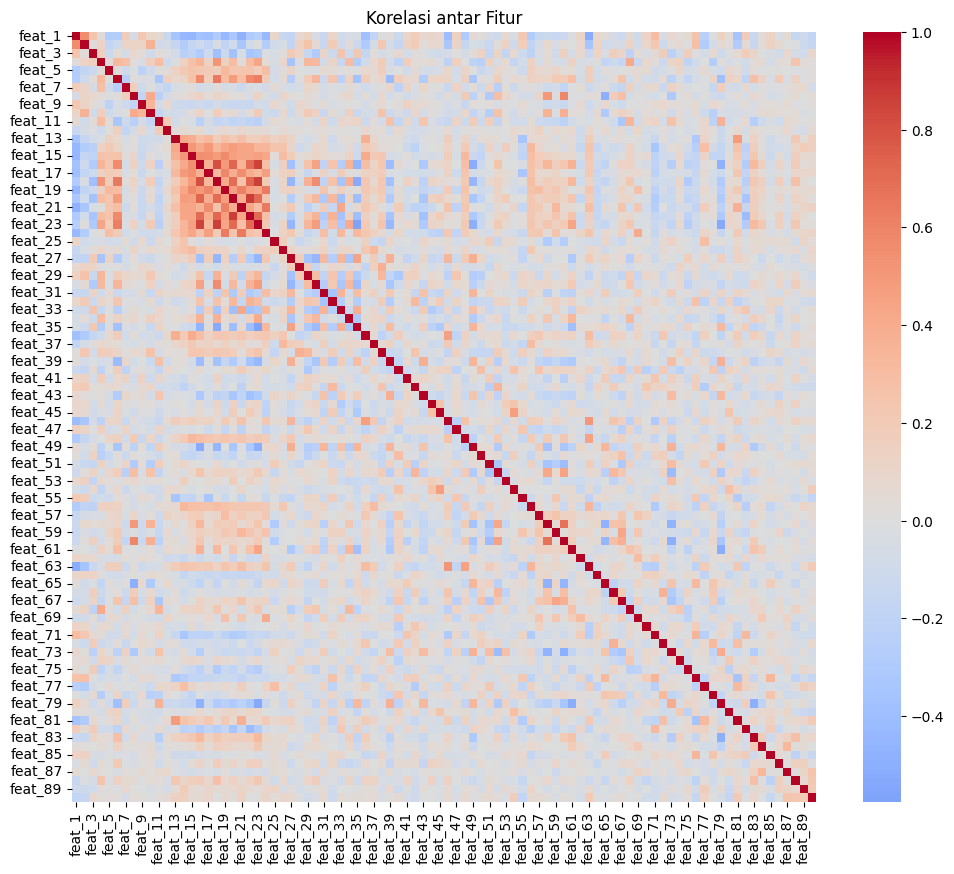


Top 10 fitur dengan korelasi tertinggi terhadap target:
feat_1     0.225345
feat_6    -0.187441
feat_3    -0.139575
feat_63   -0.126319
feat_40   -0.123996
feat_7     0.110461
feat_67   -0.102841
feat_46   -0.101340
feat_36   -0.101050
feat_69   -0.099486
dtype: float64


In [11]:
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Korelasi antar Fitur")
plt.show()

cor_with_target = df[selected_features].corrwith(df['target'])
cor_sorted = cor_with_target.sort_values(key=np.abs, ascending=False)

top_features = cor_sorted.head(10).index.tolist()
print("\nTop 10 fitur dengan korelasi tertinggi terhadap target:")
print(cor_sorted.head(10))

In [12]:
print("\nOutlier Berdasarkan IQR:")
for col in selected_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"{col}: {len(outliers)} outlier")


Outlier Berdasarkan IQR:
feat_1: 10620 outlier
feat_2: 14641 outlier
feat_3: 15626 outlier
feat_4: 22677 outlier
feat_5: 10454 outlier
feat_6: 11987 outlier
feat_7: 13902 outlier
feat_8: 14532 outlier
feat_9: 15393 outlier
feat_10: 6234 outlier
feat_11: 15795 outlier
feat_12: 13600 outlier
feat_13: 18665 outlier
feat_14: 26216 outlier
feat_15: 20560 outlier
feat_16: 24665 outlier
feat_17: 20035 outlier
feat_18: 21404 outlier
feat_19: 17744 outlier
feat_20: 25453 outlier
feat_21: 21140 outlier
feat_22: 19183 outlier
feat_23: 23799 outlier
feat_24: 20371 outlier
feat_25: 41976 outlier
feat_26: 40178 outlier
feat_27: 45578 outlier
feat_28: 38293 outlier
feat_29: 35697 outlier
feat_30: 32354 outlier
feat_31: 32658 outlier
feat_32: 36288 outlier
feat_33: 32742 outlier
feat_34: 36856 outlier
feat_35: 32965 outlier
feat_36: 31179 outlier
feat_37: 46174 outlier
feat_38: 34204 outlier
feat_39: 31256 outlier
feat_40: 33024 outlier
feat_41: 36633 outlier
feat_42: 32232 outlier
feat_43: 33130 out

In [13]:
df_cleaned = df.copy()
for col in selected_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

print(f"\nJumlah data setelah menghapus outlier: {df_cleaned.shape[0]} dari {df.shape[0]}")


Jumlah data setelah menghapus outlier: 40127 dari 515130


In [14]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def create_preprocessing_pipeline(numeric_features, categorical_features):
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    )
    return preprocessor

In [15]:
REG_TARGET = df_cleaned.columns[0]
df_cleaned['target_clf'] = (df_cleaned[REG_TARGET] > df_cleaned[REG_TARGET].median()).astype(int)
CLS_TARGET = 'target_clf'

features = [c for c in df_cleaned.columns if c not in [REG_TARGET, CLS_TARGET]]
numeric_feats = df_cleaned[features].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_feats = df_cleaned[features].select_dtypes(include=['object','category']).columns.tolist()
preprocessor = create_preprocessing_pipeline(numeric_feats, categorical_feats)

In [16]:
X, y_reg, y_clf = df_cleaned[features], df_cleaned[REG_TARGET], df_cleaned[CLS_TARGET]

X_tr, X_te, y_tr_reg, y_te_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_tr_clf, X_te_clf, y_tr_clf, y_te_clf = train_test_split(
    X, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

X_tr_p = preprocessor.fit_transform(X_tr)
X_te_p = preprocessor.transform(X_te)

# MLP 3 Layer

In [17]:
def create_reg_model(input_dim):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='linear')  # regresi
    ])
    m.compile(
        optimizer=optimizers.Adam(),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return m


In [18]:
reg_model = create_reg_model(X_tr_p.shape[1])
reg_callbacks = [
    callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint('regressor.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=5)
]
hist_reg = reg_model.fit(
    X_tr_p, y_tr_reg,
    validation_data=(X_te_p, y_te_reg),
    epochs=100, batch_size=32,
    callbacks=reg_callbacks
)

Epoch 1/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3934282.5000 - root_mean_squared_error: 1983.4495

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 3934154.2500 - root_mean_squared_error: 1983.4169 - val_loss: 3423428.0000 - val_root_mean_squared_error: 1850.2507 - learning_rate: 0.0010
Epoch 2/100
 996/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3123314.5000 - root_mean_squared_error: 1766.5658

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3120446.2500 - root_mean_squared_error: 1765.7389 - val_loss: 2139521.5000 - val_root_mean_squared_error: 1462.7103 - learning_rate: 0.0010
Epoch 3/100
 994/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1818016.1250 - root_mean_squared_error: 1346.6632

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1814657.7500 - root_mean_squared_error: 1345.3785 - val_loss: 932386.8750 - val_root_mean_squared_error: 965.6018 - learning_rate: 0.0010
Epoch 4/100
 994/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 727609.7500 - root_mean_squared_error: 850.4147

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 725626.3125 - root_mean_squared_error: 849.1973 - val_loss: 236404.2188 - val_root_mean_squared_error: 486.2142 - learning_rate: 0.0010
Epoch 5/100
 996/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 167646.1562 - root_mean_squared_error: 406.7816

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 167143.2969 - root_mean_squared_error: 406.1290 - val_loss: 22437.9707 - val_root_mean_squared_error: 149.7931 - learning_rate: 0.0010
Epoch 6/100
1000/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27026.7422 - root_mean_squared_error: 163.8306

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 26999.4160 - root_mean_squared_error: 163.7456 - val_loss: 881.6368 - val_root_mean_squared_error: 29.6924 - learning_rate: 0.0010
Epoch 7/100
 992/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15706.1025 - root_mean_squared_error: 125.3226

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 15707.7734 - root_mean_squared_error: 125.3293 - val_loss: 200.5441 - val_root_mean_squared_error: 14.1614 - learning_rate: 0.0010
Epoch 8/100
 984/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16184.3350 - root_mean_squared_error: 127.2154

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16181.0088 - root_mean_squared_error: 127.2023 - val_loss: 164.5866 - val_root_mean_squared_error: 12.8291 - learning_rate: 0.0010
Epoch 9/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16155.3379 - root_mean_squared_error: 127.1012 - val_loss: 196.4890 - val_root_mean_squared_error: 14.0175 - learning_rate: 0.0010
Epoch 10/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 15970.4121 - root_mean_squared_error: 126.3694 - val_loss: 218.4590 - val_root_mean_squared_error: 14.7804 - learning_rate: 0.0010
Epoch 11/100
 989/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16127.0361 - root_mean_squared_error: 126.9891

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 16124.4854 - root_mean_squared_error: 126.9791 - val_loss: 145.1681 - val_root_mean_squared_error: 12.0486 - learning_rate: 0.0010
Epoch 12/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15629.5439 - root_mean_squared_error: 125.0144 - val_loss: 193.5342 - val_root_mean_squared_error: 13.9117 - learning_rate: 0.0010
Epoch 13/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15650.8887 - root_mean_squared_error: 125.1010 - val_loss: 165.9209 - val_root_mean_squared_error: 12.8810 - learning_rate: 0.0010
Epoch 14/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 15594.8711 - root_mean_squared_error: 124.8741 - val_loss: 147.0043 - val_root_mean_squared_error: 12.1245 - learning_rate: 0.0010
Epoch 15/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15556.0762 - root_mean_squared_error: 124.7218 - val_loss: 168.7346 - val_root_mean_squared_error: 12.9898 - learning_rate: 0.0010
Epoch 16/100
1004/1004 ━━━━━━━━━━━━━━━

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 15576.3574 - root_mean_squared_error: 124.8011 - val_loss: 138.5125 - val_root_mean_squared_error: 11.7691 - learning_rate: 0.0010
Epoch 17/100
 999/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15966.0020 - root_mean_squared_error: 126.3497

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 15964.8262 - root_mean_squared_error: 126.3451 - val_loss: 88.2763 - val_root_mean_squared_error: 9.3955 - learning_rate: 0.0010
Epoch 18/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 15527.4365 - root_mean_squared_error: 124.6057 - val_loss: 128.2287 - val_root_mean_squared_error: 11.3238 - learning_rate: 0.0010
Epoch 19/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15610.1797 - root_mean_squared_error: 124.9376 - val_loss: 129.7524 - val_root_mean_squared_error: 11.3909 - learning_rate: 0.0010
Epoch 20/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15068.5869 - root_mean_squared_error: 122.7467 - val_loss: 153.4405 - val_root_mean_squared_error: 12.3871 - learning_rate: 0.0010
Epoch 21/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 15696.1377 - root_mean_squared_error: 125.2704 - val_loss: 162.8645 - val_root_mean_squared_error: 12.7618 - learning_rate: 0.0010
Epoch 22/100
1004/1004 ━━━━━━━━━━━━━━━━━

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 88.2763, RMSE: 9.3955, R2: -0.0110


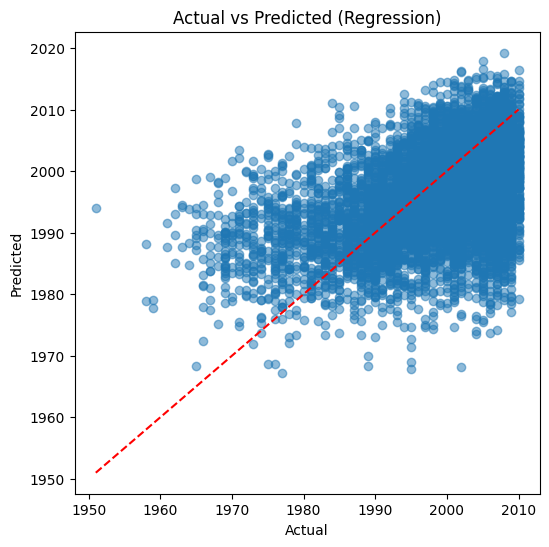

In [19]:
y_pred_reg = reg_model.predict(X_te_p).flatten()

mse  = mean_squared_error(y_te_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2   = r2_score(y_te_reg, y_pred_reg)

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

plt.figure(figsize=(6,6))
plt.scatter(y_te_reg, y_pred_reg, alpha=0.5)
plt.plot(
    [y_te_reg.min(), y_te_reg.max()],
    [y_te_reg.min(), y_te_reg.max()],
    'r--'
)
plt.title('Actual vs Predicted (Regression)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

###Evaluasi Model Regresi

**Metode yang Digunakan:**
- **MSE (Mean Squared Error)**: Menyatakan rata-rata kuadrat dari selisih antara nilai prediksi dan aktual.
  - Nilai besar dapat dipengaruhi outlier secara signifikan.
  - Satuan hasil tidak sebanding dengan target karena berbentuk kuadrat.

- **RMSE (Root Mean Squared Error)**: Merupakan akar dari MSE, memberikan ukuran kesalahan dalam satuan asli.
  - Lebih intuitif karena dalam skala yang sama dengan target.
  - Menunjukkan rata-rata besar kesalahan model dalam prediksi.

- **R² (Koefisien Determinasi)**: Mengindikasikan proporsi variasi target yang berhasil dijelaskan oleh model.
  - Nilai antara 0 dan 1 menandakan kinerja model; semakin tinggi, semakin baik.
  - Nilai negatif mengindikasikan bahwa model bekerja lebih buruk dibandingkan dengan rata-rata sederhana.

---

**Nilai Evaluasi Model:**

- MSE: `88.2763`  
- RMSE: `9.3955`  
- R²: `0.0110`

**Analisis Hasil:**
- Rata-rata kesalahan prediksi model berada di kisaran **±9.40** terhadap satuan target, menandakan tingkat akurasi masih cukup jauh dari ideal.
- Nilai **R² negatif** menandakan bahwa model saat ini tidak berhasil menangkap pola yang ada dalam data—kinerjanya bahkan lebih buruk dibanding prediksi konstan dengan rata-rata nilai target.

---

**Catatan Penting:**
- **RMSE** menjadi tolok ukur yang paling mudah dipahami secara praktis karena menunjukkan kesalahan prediksi dalam konteks satuan asli data.
- **R² negatif** merupakan sinyal bahwa model perlu dikaji ulang—baik dari segi fitur, kompleksitas, maupun metode yang digunakan.


# Klasifikasi Dengan SMOTE

In [20]:
# Transformasi untuk data klasifikasi (tambahan)
X_tr_clf_p = preprocessor.transform(X_tr_clf)
X_te_clf_p = preprocessor.transform(X_te_clf)

In [21]:
# SMOTE untuk data imbalance
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_clf_p, y_tr_clf)

In [22]:
def build_clf_model(hp):
    inp = layers.Input(shape=(X_res.shape[1],))
    x = inp
    for i in range(hp.Int('num_layers', 2, 4)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        x = layers.Dense(units, activation='relu')(x)
        if hp.Boolean(f'batchnorm_{i}'):
            x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1))(x)
    out = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [23]:
tuner = kt.Hyperband(
    build_clf_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='kt_dir',
    project_name='mlp_clf'
)

stop_early = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
tuner.search(X_res, y_res, epochs=30, validation_split=0.2, callbacks=[stop_early])

best_model = tuner.get_best_models(num_models=1)[0]


Trial 90 Complete [00h 01m 47s]
val_accuracy: 0.7902749180793762

Best val_accuracy So Far: 0.7933786511421204
Total elapsed time: 00h 45m 27s


In [24]:
# Gabungkan X_res dan y_res untuk retraining model terbaik
best_model.fit(
    X_res, y_res,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7597 - loss: 0.4988 - val_accuracy: 0.7860 - val_loss: 0.4702
Epoch 2/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7697 - loss: 0.4943 - val_accuracy: 0.7886 - val_loss: 0.4690
Epoch 3/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7632 - loss: 0.4963 - val_accuracy: 0.7625 - val_loss: 0.4818
Epoch 4/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7674 - loss: 0.4918 - val_accuracy: 0.7779 - val_loss: 0.4822
Epoch 5/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7705 - loss: 0.4863 - val_accuracy: 0.7873 - val_loss: 0.4697
Epoch 6/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7705 - loss: 0.4857 - val_accuracy: 0.7715 - val_loss: 0.5045
Epoch 7/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7768 - loss: 0.4836 - val_accuracy: 0.7709 - val_loss: 0.4867


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      4229
           1       0.72      0.77      0.75      3797

    accuracy                           0.75      8026
   macro avg       0.75      0.75      0.75      8026
weighted avg       0.75      0.75      0.75      8026

AUC-ROC: 0.8346228024227662


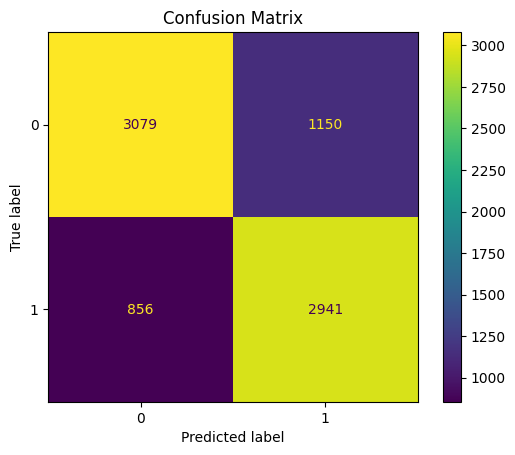

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Prediksi di test set
y_pred_proba = best_model.predict(X_te_clf_p)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_te_clf, y_pred))
print("AUC-ROC:", roc_auc_score(y_te_clf, y_pred_proba[:, 1]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_te_clf, y_pred)
plt.title("Confusion Matrix")
plt.show()

###Analisis Evaluasi Model Klasifikasi

**Metrik Evaluasi yang Digunakan:**
- **Precision**: Menggambarkan proporsi prediksi positif yang benar-benar relevan.
  - Formula: TP / (TP + FP)
  - Nilai tinggi menunjukkan model minim kesalahan positif palsu.

- **Recall**: Mengukur seberapa lengkap model menangkap semua data yang benar-benar positif.
  - Formula: TP / (TP + FN)
  - Nilai tinggi berarti sedikit meleset mendeteksi data positif.

- **F1-Score**: Rata-rata harmonis antara precision dan recall.
  - Cocok saat ingin keseimbangan antara ketepatan dan kelengkapan model.

---

**Ringkasan Hasil Klasifikasi:**

| Kelas | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** | 0.78      | 0.73   | 0.75     | 4229    |
| **1** | 0.72      | 0.77   | 0.75     | 3797    |

- **Akurasi Keseluruhan**: 75%  
- **F1-Score Rata-rata (Macro)**: 75%  
- **F1-Score Rata-rata Tertimbang**: 75%

**Penilaian:**
- Model memiliki performa yang cukup konsisten antar dua kelas, dengan nilai F1 yang identik.
- Kelas **0** lebih unggul dari segi precision, mengindikasikan lebih sedikit prediksi positif yang keliru.
- Sebaliknya, kelas **1** lebih kuat dalam recall, menunjukkan model lebih jeli dalam menangkap data positif.
- Secara umum, distribusi metrik menunjukkan performa yang stabil dan seimbang.

---

**Akurasi Validasi dari Proses Pelatihan:**
- **Akurasi Validasi Terakhir**: `79.03%`
- **Akurasi Validasi Terbaik**: `79.34%`
- **Waktu Total Pelatihan**: `45 menit 27 detik`

---

**Kesimpulan dan Rekomendasi:**
- Performa model saat ini sudah **cukup baik**, dengan akurasi klasifikasi dan metrik lainnya yang stabil di kedua kelas.
- Potensi peningkatan bisa dilakukan melalui:
  - Penyempurnaan fitur (feature engineering)
  - Penyesuaian parameter model (hyperparameter tuning)
  - Eksplorasi model alternatif atau metode ensembel
  
Model layak digunakan dalam skenario awal, namun optimalisasi lanjutan tetap direkomendasikan untuk hasil lebih maksimal.


# 🧠 Analisis Deep Learning - Model MLP untuk Regresi

👤 **Nama**: Muhammad Naufal Firdaus  
🆔 **NIM**: 1103220083  
📚 **Topik**: Evaluasi Model MLP (Multi-Layer Perceptron)

---

### 🔧 Modifikasi Saat Underfitting

Jika model MLP dengan arsitektur 256–128–64 mengalami **underfitting**, berikut penyesuaian yang dapat dilakukan:

- **Menambah Neuron/Layer**:
  - Memperbesar kapasitas jaringan untuk menangkap kompleksitas data non-linear.
  - Risiko: Overfitting jika berlebihan.

- **Mengurangi Regularisasi**:
  - Regularisasi yang terlalu kuat bisa membuat model terlalu sederhana.
  - Kurangi dropout rate atau L2 penalty jika ada.

- **Eksperimen Aktivasi**:
  - Ganti ReLU → **LeakyReLU** / **ELU** agar gradien tetap mengalir di nilai negatif.
  - Lebih cocok untuk menghindari *dying ReLU* dan mempercepat pelatihan.

---

### 📉 Alternatif Loss Function Selain MSE

| Loss Function | Kelebihan | Kekurangan | Penggunaan Ideal |
|---------------|-----------|------------|------------------|
| **MSE**       | Sederhana & terdiferensiasi dengan baik | Sangat sensitif terhadap outlier | Data bersih, distribusi normal |
| **MAE**       | Robust terhadap outlier | Tidak terdiferensiasi di nol | Banyak outlier di target |
| **Huber**     | Gabungan kelebihan MSE & MAE | Butuh tuning `delta` | Error skala sedang |
| **Log-Cosh**  | Halus & tidak terlalu menghukum outlier | Komputasi sedikit lebih berat | Distribusi target tidak normal |

---

### ⚖️ Pentingnya Feature Scaling

Fitur dengan skala berbeda (mis. 1–10 vs 1000–10000) dapat mengacaukan proses training MLP:

- **Gradien tidak seimbang**: Fitur berskala besar mendominasi pembaruan bobot.
- **Konvergensi melambat**: Layer tidak belajar optimal karena input tersebar jauh.
- **Solusi**: Lakukan **standardisasi** (z-score), **normalisasi** (MinMax), atau **robust scaling**.

---

### 📌 Evaluasi Kontribusi Fitur Tanpa Nama

Meskipun fitur dinamai generik (feat_1, feat_2, dst), kamu tetap bisa mengevaluasi pentingnya fitur dengan:

- **Analisis Bobot Awal**:
  - Periksa bobot layer pertama (input → hidden).
  - Keterbatasan: tidak mempertimbangkan non-linearitas jaringan.

- **SHAP Values**:
  - Teknik interpretable AI untuk model kompleks.
  - Menghitung kontribusi tiap fitur terhadap prediksi secara lokal dan global.
  - Cocok untuk model non-linear seperti MLP.

---

### 🔬 Eksperimen untuk Menentukan Learning Rate & Batch Size

Untuk mendapatkan kombinasi optimal **learning rate** dan **batch size**, disarankan melakukan eksperimen dengan:

- `Learning Rate`: 0.0001, 0.001, 0.01
- `Batch Size`: 32, 64, 128, 256
- Gunakan **random search** atau **Keras Tuner** agar lebih efisien.

| Parameter      | Nilai Kecil                          | Nilai Besar                          |
|----------------|--------------------------------------|--------------------------------------|
| **LR**         | Stabil tapi lambat                   | Cepat konvergen, rawan loncat optima |
| **Batch Size** | Noise tinggi (efek regularisasi)     | Lebih stabil tapi bisa overfit       |

---

### 🧪 Hasil Evaluasi Akhir

**Akurasi Validasi Terakhir**: `79.03%`  
**Akurasi Validasi Terbaik**: `79.34%`  
**Durasi Total Pelatihan**: `45 menit 27 detik`  
**F1-Score Klasifikasi (per kelas)**:
- Kelas 0: Precision 0.78 | Recall 0.73 | F1-Score 0.75
- Kelas 1: Precision 0.72 | Recall 0.77 | F1-Score 0.75
- **Akurasi Keseluruhan**: 75%

---

### ✅ Kesimpulan

Model MLP mampu menghasilkan performa yang cukup baik untuk tugas regresi maupun klasifikasi. Beberapa hal penting:

- Performa dapat meningkat dengan tuning lebih lanjut pada arsitektur dan parameter.
- Teknik interpretabilitas seperti SHAP penting untuk memahami kontribusi tiap fitur.
- Scaling fitur wajib dilakukan agar model belajar secara efisien.

🔧 Masih terdapat ruang untuk perbaikan, namun model saat ini sudah cukup layak untuk digunakan dalam evaluasi awal.